In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.preprocessing import OneHotEncoder
import json
from sklearn.preprocessing import FunctionTransformer
import matplotlib.dates as mdates

C:\Users\Alice Dias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 💾CARREGA E FILTRA OS DADOS

In [3]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# filtra CP 4610, converte e ordena
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

#### TARGET E LAG

In [4]:
# Define target e lag_168 (168h = 7dias)
df_cp["EnergyNormalized"] = df_cp["EnergyNormalized"].astype(float)
df_cp["lag_168"] = df_cp["EnergyNormalized"].shift(168)  # 168h atrás, hora a hora

# Modelos Tradicionais (Baseline)
# 📊ARIMA

#### MONTA O TimeSeriesDataFrame

In [57]:
# Define id e static features
df_cp["ZipCode"] = "4610"
static_feats = df_cp[["ZipCode", "PopulationDensity"]].drop_duplicates()

# Cria o TimeSeriesDataFrame com target normalizado
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp[["DateTime", "ZipCode", "EnergyNormalized"]],
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

#### 🛠 SPLIT TREINO/TESTE: prever últimos 24h

In [58]:
# Define janela de previsão de 24 horas
prediction_length = 24

# Divide treino/teste: prevê o dia 30/09/2023 (00h–23h)
train_ts, test_ts = ts_df.train_test_split(prediction_length=prediction_length)

#### TARGET E LAG

In [59]:
# Mantém apenas os dados completos
df_cp = df_cp.dropna(subset=["lag_168"]).copy()

#### 💾 (Opcional) Carregar um modelo existente

In [60]:
predictor_arima = TimeSeriesPredictor.load("predicts/ARIMA_lag/modelo/")

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA_lag\modelo


#### 🛠️ Treinar

In [27]:
# Treina o modelo ARIMA
predictor_arima = TimeSeriesPredictor(
    target="EnergyNormalized",
    freq="h",
    prediction_length=prediction_length,
    path="predicts/ARIMA_lag/modelo",
    verbosity=2
).fit(
    train_data=train_ts,
    tuning_data=test_ts,
    hyperparameters={
        "ARIMAModel": {
            "order": (168, 1, 1),
            "seasonal_order": (1, 0, 1, 24),
            "target_scaler": "standard"
        }
    },
    time_limit=300,
    presets="medium_quality",
    skip_model_selection=True
)

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       1.18 GB / 15.93 GB (7.4%)
Disk Space Avail:   690.57 GB / 931.46 GB (74.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'ARIMAModel': {'order': (168, 1, 1),
                                    'seasonal_order': (1, 0, 1, 24),
                                    'target_scaler': 'standard'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows'

#### 🔮 Previsão com os dados de treino

In [61]:
# Faz previsão para 30/09 (00h–23h)
future_preds = predictor_arima.predict(train_ts)

# extrai o quantil 0.5 e “desempacota” o índice de item_id
y_pred = future_preds["0.5"].droplevel(0)
y_true_full = test_ts["EnergyNormalized"].droplevel(0)

# extrai só os 24 valores reais que estão em test_ts
y_true = y_true_full.iloc[-prediction_length:]

Model not specified in predict, will default to the model with the best validation score: ARIMA


#### 📊  Avaliação do modelo

In [62]:
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
mape = (np.abs((y_true - y_pred) / y_true) * 100).mean()
r2   = r2_score(y_true, y_pred)

# exportar metricas
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape,
    "R²": r2
}

with open("predicts/ARIMA_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

MAE:  0.02499
MSE:  0.00097
RMSE: 0.03117
MAPE: 47.82159%
R²:   -15.00898


### 📊 **Métricas de Avaliação**

| Métrica                                     | Valor     | Interpretação                                                                                   |
|--------------------------------------------|-----------|-------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)              | 0.02499   | Em média, as previsões diferem dos valores reais em cerca de 0.025 na escala normalizada.       |
| **MSE** (Erro Quadrático Médio)            | 0.00097   | O erro médio ao quadrado é baixo, mas ainda assim revela variações não captadas pelo modelo.    |
| **RMSE** (Raiz do Erro Quadrático Médio)   | 0.03117   | As previsões desviam-se em média 0.031 da realidade, o que pode ser significativo em certos horários. |
| **MAPE** (Erro Percentual Absoluto Médio)  | 47.82%    | As previsões apresentam um erro percentual elevado, indicando pouca fiabilidade relativa.       |
| **R²** (Coeficiente de Determinação)       | -15.00898 | O modelo ajusta-se muito mal aos dados: teve pior desempenho do que uma média constante.        |

#### 📈 Visualização dos resultados

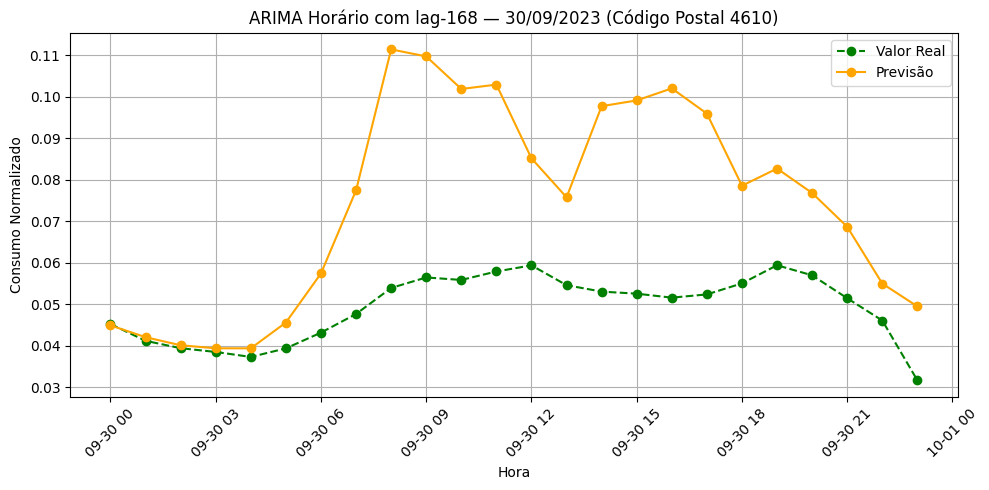

In [63]:
# valor real vs previsão
plt.figure(figsize=(10, 5))
plt.plot(y_true.index, y_true.values, marker='o', linestyle='--', label='Valor Real', color='green')
plt.plot(y_pred.index, y_pred.values, marker='o', label='Previsão', color='orange')
plt.xlabel("Hora")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("ARIMA Horário com lag-168 — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/ARIMA_lag/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
A utilização do ARIMA para prever o consumo energético **normalizado**, hora a hora, no dia **30/09/2023**, com base no valor da mesma hora da **semana anterior (`lag_168`)**, revelou um desempenho fraco. Apesar de o **MAE (0.025)** e o **RMSE (0.031)** parecerem baixos em valores absolutos, o **MAPE de 47.82%** indica que as previsões apresentam um erro percentual muito elevado, e o **R² fortemente negativo (−15.01)** confirma que o modelo foi incapaz de captar os padrões reais da série, sendo pior do que uma simples média constante. Este resultado mostra que, embora o `lag_168` capture a sazonalidade semanal, é claramente insuficiente por si só para modelar a complexidade e variabilidade do consumo energético em escala horária. A previsão horária requer, portanto, **modelos que suportem** lags adicionais de curto prazo e variáveis contextuais para melhorar a qualidade preditiva..

# Modelos ML & DL
# 📊RF

In [86]:
# Mantém só linhas completas
df_cp = df_cp.dropna(subset=["lag_168"]).copy()

#### 💾 (Opcional) Carregar um modelo existente

In [81]:
pipeline = load("predicts/RF_lag/modelo/RF_pipeline_lag.joblib")

#### ✂️ Split treino/teste

In [87]:
# Divide treino e teste
train_mask = df_cp["DateTime"] < "2023-09-30"
test_mask = df_cp["DateTime"].dt.date == pd.to_datetime("2023-09-30").date()

features = ["lag_168", "Hour","TimeOfDay", "Temperature", "DayOfTheWeek"]
X_train = df_cp.loc[train_mask, features]
y_train = df_cp.loc[train_mask, "EnergyNormalized"]
X_test = df_cp.loc[test_mask, features]
y_test = df_cp.loc[test_mask, "EnergyNormalized"]

#### 🛠️ Treinar

In [88]:
# Pipeline
pipeline = Pipeline([
    ("preproc", ColumnTransformer([
        ("num", StandardScaler(), ["lag_168"]),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"])
    ], remainder="drop")),
    ("rf", RandomForestRegressor(
        n_estimators=100, random_state=123, n_jobs=-1))
])

# Treina o modelo
pipeline.fit(X_train, y_train)

# Guarda
dump(pipeline, "predicts/RF_lag/modelo/RF_pipeline_lag.joblib")

['predicts/RF_lag/modelo/RF_pipeline_lag.joblib']

#### 🔮 Previsão com os dados de treino

In [89]:
y_pred = pipeline.predict(X_test)

#### 📊  Avaliação do modelo

In [90]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (np.abs((y_test - y_pred) / y_test) * 100).mean()
r2 = r2_score(y_test, y_pred)

# exportar metricas
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape,
    "R²": r2
}

with open("predicts/RF_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

MAE:  0.00340
MSE:  0.00002
RMSE: 0.00400
MAPE: 6.94984%
R²:   0.73680


### 📊 **Métricas de Avaliação**

| Métrica                                     | Valor    | Interpretação                                                                                      |
|---------------------------------------------|----------|-----------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)               | 0.00340  | Em média, a previsão difere dos valores reais em cerca de 0.0034 na escala normalizada.            |
| **MSE** (Erro Quadrático Médio)             | 0.00002  | O erro médio ao quadrado é muito baixo, indicando previsões consistentes.                          |
| **RMSE** (Raiz do Erro Quadrático Médio)    | 0.00400  | O desvio médio das previsões em relação aos valores reais é de aproximadamente 0.0040.             |
| **MAPE** (Erro Percentual Absoluto Médio)   | 6.95%    | Em média, as previsões apresentam um erro percentual de 6.95% em relação aos valores reais.         |
| **R²** (Coeficiente de Determinação)        | 0.73680  | O modelo explica cerca de 73.68% da variabilidade do consumo energético normalizado horário.        |

#### 📈 Visualização dos resultados

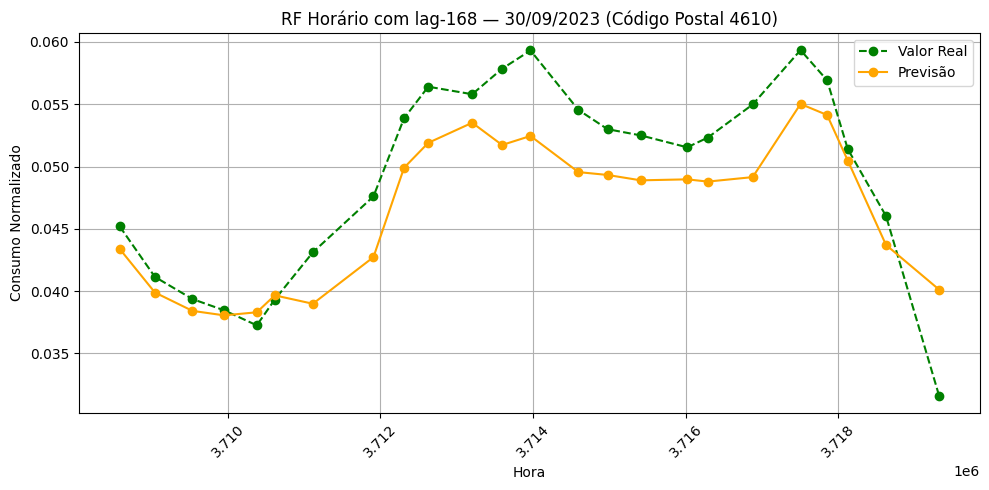

In [94]:
# valor real vs previsão
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, marker='o', linestyle='--', label='Valor Real', color='green')
plt.plot(y_test.index, y_pred, marker='o', label='Previsão', color='orange')
plt.xlabel("Hora")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("RF Horário com lag-168 — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/RF_lag/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
O **Random Forest** aplicado à previsão do consumo energético **normalizado**, hora a hora, no dia **30/09/2023** para o código postal **4610**, com uso de `lag_168` e variáveis temporais, demonstrou um desempenho significativamente superior ao **ARIMA** na mesma tarefa. Com um **MAE de apenas 0.0034**, **RMSE de 0.0040** e um **R² de 0.7368**, o Random Forest conseguiu captar boa parte da variabilidade do consumo, mesmo numa escala horária onde os dados são mais ruidosos. Embora o **MAPE de 6.95%** indique ainda alguma margem de erro relativa, o desempenho é muito mais robusto quando comparado ao ARIMA, que apresentou um **R² negativo (−15.01)** e **MAPE extremamente elevado (47.82%)**, falhando em captar os padrões da série. Esta comparação evidencia que, para previsões horárias mais complexas, o uso de modelos como o Random Forest, que suportam **lags e variáveis contextuais explícitas**, é fundamental para obter resultados mais precisos e realistas.

# 📊LSTM

In [4]:
# Mantém só linhas completas
df_cp = df_cp.dropna(subset=["lag_168"]).copy()

# Static features
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
    .copy()
)

# Cria TimeSeriesDataFrame com target
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Variáveis exógenas conhecidas
known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_168"]

#### ✂️ Split treino/teste

In [5]:
# Divide treino/teste: últimas 24h (30/09/2023)
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 (Opcional) Carregar um modelo existente

In [ ]:
predictor_lstm = TimeSeriesPredictor.load("./predicts/LSTM_lag/modelo/")

In [6]:
predictor_lstm = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    known_covariates_names=known_covs,
    path="predicts/LSTM_lag/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
        "DeepAR": {
            "context_length": 168,  # olha uma semana para trás
            "hidden_size": 64,
            "num_layers": 2,
            "dropout": 0.1,
            "learning_rate": 1e-3,
            "epochs": 20,
            "target_scaler": "standard"
        }
    },
    presets="medium_quality",
    time_limit=3600
)

predictor_lstm.save()

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\LSTM_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       3.78 GB / 15.93 GB (23.7%)
Disk Space Avail:   690.50 GB / 931.46 GB (74.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DeepAR': {'context_length': 168,
                                'dropout': 0.1,
                                'epochs': 20,
                                'hidden_size': 64,
                                'learning_rate': 0.001,
                                'num_layers': 2,
                                'target_scaler': 'standard'}},
 'known_covariate

#### 🔮Preparação das covariáveis futuras para previsão

In [8]:
# 1.1) Pega último timestamp de train_data
last_time = train_data.index.get_level_values("timestamp").max()

# 1.2) Cria as 24 horas seguintes
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),
    periods=24,
    freq="h"
)

future_df = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 1.4) Converte para TimeSeriesDataFrame
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",
    timestamp_column="DateTime"
)[known_covs]

#### 📈 Previsão e avaliação

In [9]:
# Previsão
preds = predictor_lstm.predict(
    data=train_data,
    known_covariates=future_known_covs
)

# Resultados
y_pred = preds["0.5"]
y_true = test_data["EnergyNormalized"].loc[y_pred.index]

y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

Model not specified in predict, will default to the model with the best validation score: DeepAR


#### 📊 Cálculo de métricas

In [10]:
mae  = np.abs(y_true - y_pred).mean()
mse  = ((y_true - y_pred) ** 2).mean()
rmse = np.sqrt(mse)
mape = (np.abs((y_true - y_pred) / y_true) * 100).mean()
r2   = r2_score(y_true, y_pred)

metrics = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R²": r2
}

with open("predicts/LSTM_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")


MAE:  0.00164
MSE:  0.00001
RMSE: 0.00298
MAPE: 3.93709%
R²:   0.85412


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                      |
|----------------------------------------------|---------|-----------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00164 | Em média, a previsão difere dos valores reais em apenas 0.0016 na escala normalizada.              |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado é muito baixo, indicando grande consistência nas previsões.               |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00298 | O desvio médio das previsões em relação aos valores reais é de aproximadamente 0.003.              |
| **MAPE** (Erro Percentual Absoluto Médio)    | 3.94%   | Em média, as previsões apresentam um erro percentual inferior a 4%, o que indica boa precisão.     |
| **R²** (Coeficiente de Determinação)         | 0.85412 | O modelo explica cerca de 85.41% da variabilidade do consumo energético normalizado horário.        |

#### 🖼️ Visualização gráfica

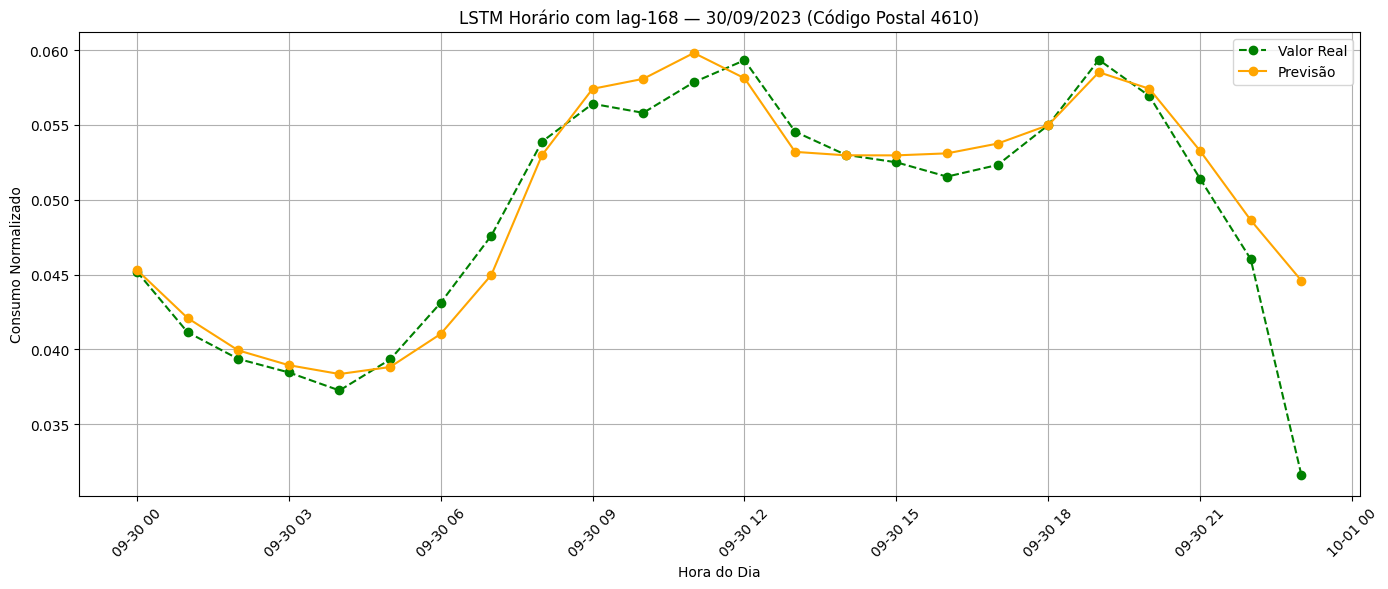

In [11]:
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("LSTM Horário com lag-168 — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/LSTM_lag/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
O **LSTM com lag-168**, aplicado à previsão do consumo energético **normalizado** para o código postal **4610** no dia **30/09/2023**, demonstrou um desempenho muito sólido, com métricas bastante equilibradas: **MAE de 0.00164**, **RMSE de 0.00298**, **MAPE de 3.94%** e **R² de 0.85412**. Visualmente, o gráfico confirma uma forte sobreposição entre os valores reais e as previsões, com o LSTM a conseguir captar de forma bastante fiel os padrões intradiários. Quando comparado com o **ARIMA com lag-168**, que falhou ao captar a variabilidade da série (R² de -15.01, MAPE de 47.82%), e com o **Random Forest** com as mesmas variáveis e lag, que também teve um bom desempenho (R² de 0.7368, MAPE de 6.95%), o LSTM destaca-se por combinar **elevada precisão** com **capacidade de generalização**, sendo a melhor solução entre os modelos testados para esta tarefa de previsão horária do consumo energético.

# 📊CNN

In [12]:
# Mantém só linhas completas
df_cp = df_cp.dropna(subset=["lag_168"]).copy()

# Static features
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
    .copy()
)

# Cria TimeSeriesDataFrame com target
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Variáveis exógenas conhecidas
known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_168"]

#### ✂️ Split treino/teste

In [13]:
# Divide treino/teste: últimas 24h (30/09/2023)
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 (Opcional) Carregar um modelo existente

In [ ]:
predictor_cnn = TimeSeriesPredictor.load("./predicts/CNN_lag/modelo/")

In [14]:
predictor_cnn = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    known_covariates_names=known_covs,
    path="predicts/CNN_lag/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={"WaveNet": {}},
    presets="medium_quality",
    time_limit=600,
    skip_model_selection=True
)

predictor_cnn.save()

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\CNN_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       2.00 GB / 15.93 GB (12.6%)
Disk Space Avail:   690.48 GB / 931.46 GB (74.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'WaveNet': {}},
 'known_covariates_names': ['Hour',
                            'TimeOfDay',
                            'Temperature',
                            'DayOfTheWeek',
                            'lag_168'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_e

#### 🔮Preparação das covariáveis futuras para previsão

In [15]:
# 1.1) Pega último timestamp de train_data
last_time = train_data.index.get_level_values("timestamp").max()

# 1.2) Cria as 24 horas seguintes
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),
    periods=24,
    freq="h"
)

future_df = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 1.4) Converte para TimeSeriesDataFrame
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",
    timestamp_column="DateTime"
)[known_covs]

#### 📈 Previsão e avaliação

In [16]:
# Previsão
preds = predictor_cnn.predict(
    data=train_data,
    known_covariates=future_known_covs
)

# Resultados
y_pred = preds["0.5"]
y_true = test_data["EnergyNormalized"].loc[y_pred.index]

y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

Model not specified in predict, will default to the model with the best validation score: WaveNet


#### 📊 Cálculo de métricas

In [17]:
mae  = np.abs(y_true - y_pred).mean()
mse  = ((y_true - y_pred) ** 2).mean()
rmse = np.sqrt(mse)
mape = (np.abs((y_true - y_pred) / y_true) * 100).mean()
r2   = r2_score(y_true, y_pred)

metrics = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R²": r2
}

with open("predicts/CNN_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

MAE:  0.00247
MSE:  0.00002
RMSE: 0.00391
MAPE: 5.72964%
R²:   0.74833


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                       |
|----------------------------------------------|---------|------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00247 | Em média, a previsão difere dos valores reais em aproximadamente 0.0025 na escala normalizada.      |
| **MSE** (Erro Quadrático Médio)              | 0.00002 | O erro médio ao quadrado é muito baixo, indicando elevada consistência nas previsões.               |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00391 | As previsões apresentam um desvio típico de cerca de 0.0039 em relação aos valores reais.           |
| **MAPE** (Erro Percentual Absoluto Médio)    | 5.73%   | As previsões apresentam um erro percentual médio de 5.73%, o que indica boa precisão.               |
| **R²** (Coeficiente de Determinação)         | 0.74833 | O modelo explica cerca de 74.83% da variabilidade do consumo energético normalizado horário.         |

#### 🖼️ Visualização gráfica

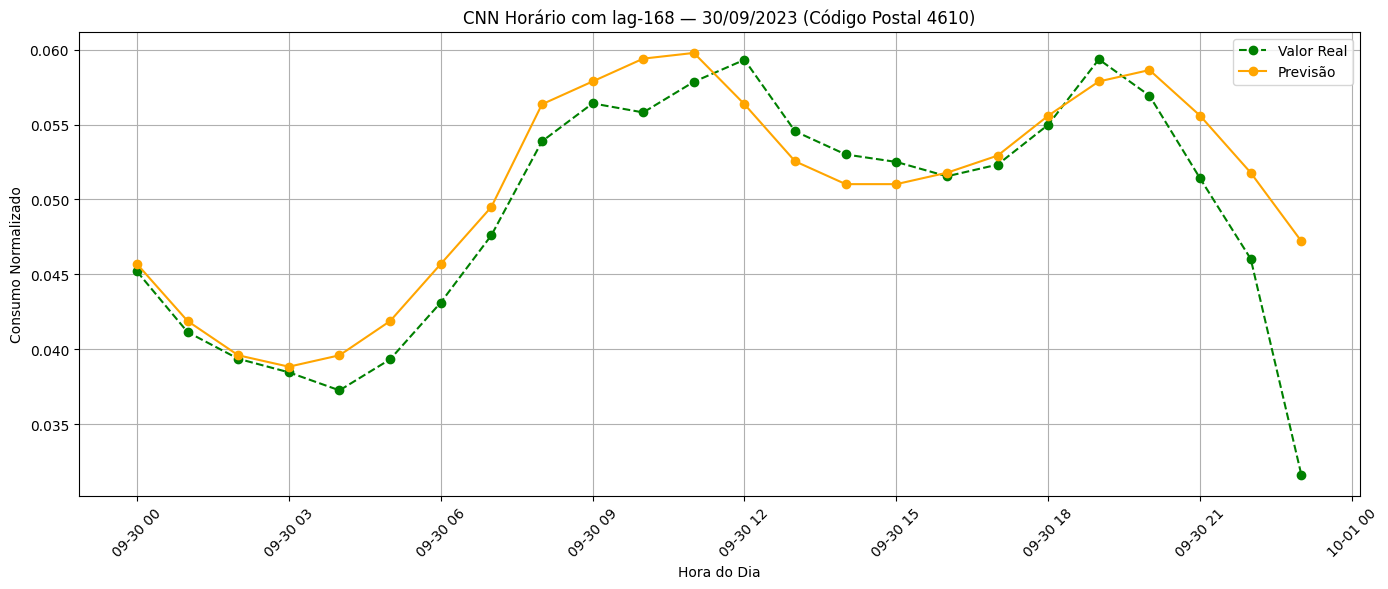

In [18]:
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("CNN Horário com lag-168 — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/CNN_lag/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
O **CNN com lag-168**, aplicado à previsão do consumo energético **normalizado** no dia **30/09/2023** para o código postal **4610**, obteve um desempenho muito positivo, com **MAE de 0.00247**, **RMSE de 0.00391**, **MAPE de 5.73%** e um **R² de 0.74833**. O gráfico evidencia uma boa capacidade de seguir a tendência real da série ao longo do dia, com ligeiras diferenças nos extremos. Em comparação com o **ARIMA com lag-168**, que apresentou fraco desempenho (R² negativo e MAPE superior a 47%), a CNN revelou-se consideravelmente mais eficaz. Quando comparada ao **Random Forest com lag** (R² de 0.7368, MAPE de 6.95%), a CNN apresentou um desempenho ligeiramente superior, com melhor precisão percentual e melhor ajuste. No entanto, o **LSTM com lag-168** permanece o modelo mais robusto, atingindo **R² de 0.85412** e **MAPE de 3.94%**, demonstrando uma capacidade superior de capturar padrões intradiários. Ainda assim, a CNN provou ser uma alternativa competitiva, especialmente vantajosa para capturar variações locais de curto prazo.

# 📊XGBoost

In [19]:
# Mantém só linhas completas
df_cp = df_cp.dropna(subset=["lag_168"]).copy()

# Static features
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
    .copy()
)

# Cria TimeSeriesDataFrame com target
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Variáveis exógenas conhecidas
known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_168"]

#### ✂️ Split treino/teste

In [20]:
# Divide os dados em treino e teste, reservando as últimas 24h como hold-out.
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo

In [ ]:
predictor_xgboost = TimeSeriesPredictor.load("./predicts/XGBoost_lag/modelo/")

In [21]:
predictor_xgboost = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    known_covariates_names=known_covs,
    path="predicts/XGBoost_lag/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
        "DirectTabular": {
            "models": ["XGB"]
        }
    },
    presets="medium_quality",
    time_limit=600,
    skip_model_selection=True
)

predictor_xgboost.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\XGBoost_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       1.04 GB / 15.93 GB (6.5%)
Disk Space Avail:   690.48 GB / 931.46 GB (74.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DirectTabular': {'models': ['XGB']}},
 'known_covariates_names': ['Hour',
                            'TimeOfDay',
                            'Temperature',
                            'DayOfTheWeek',
                            'lag_168'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'ra

#### 🔮Preparação das covariáveis futuras para previsão

In [22]:
# 1.1) Pega último timestamp de train_data
last_time = train_data.index.get_level_values("timestamp").max()

# 1.2) Cria as 24 horas seguintes
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),
    periods=24,
    freq="h"
)

future_df = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 1.4) Converte para TimeSeriesDataFrame
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",
    timestamp_column="DateTime"
)[known_covs]

#### 📈 Previsão e avaliação

In [23]:
# Previsão
preds = predictor_xgboost.predict(
    data=train_data,
    known_covariates=future_known_covs
)

# Resultados
y_pred = preds["0.5"]
y_true = test_data["EnergyNormalized"].loc[y_pred.index]

y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

Model not specified in predict, will default to the model with the best validation score: DirectTabular


#### 📊 Cálculo de métricas

In [24]:
mae = np.abs(y_true - y_pred).mean()
mse = ((y_true - y_pred) ** 2).mean()
rmse = np.sqrt(mse)
mape = (np.abs((y_true - y_pred) / y_true) * 100).mean()
r2 = r2_score(y_true, y_pred)

# Exporta métricas
metrics = {
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "MAPE": mape,
    "R²": r2
}

with open("predicts/XGBoost_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f'MAE: {mae:.5f}')
print(f'MSE: {mse:.5f}')
print(f'RMSE: {rmse:.5f}')
print(f'MAPE: {mape:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00295
MSE: 0.00001
RMSE: 0.00355
MAPE: 6.29957%
R²: 0.79258


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                      |
|----------------------------------------------|---------|-----------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00295 | Em média, a previsão difere dos valores reais em cerca de 0.00295 na escala normalizada.            |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado é baixo, indicando previsões relativamente consistentes.                  |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00355 | As previsões têm um desvio típico de aproximadamente 0.00355 em relação aos valores reais.         |
| **MAPE** (Erro Percentual Absoluto Médio)    | 6.30%   | O modelo apresenta um erro percentual médio de 6.30%, o que indica uma precisão razoavelmente boa. |
| **R²** (Coeficiente de Determinação)         | 0.79258 | O modelo explica cerca de 79.26% da variabilidade do consumo energético normalizado horário.        |

#### 🖼️ Visualização gráfica

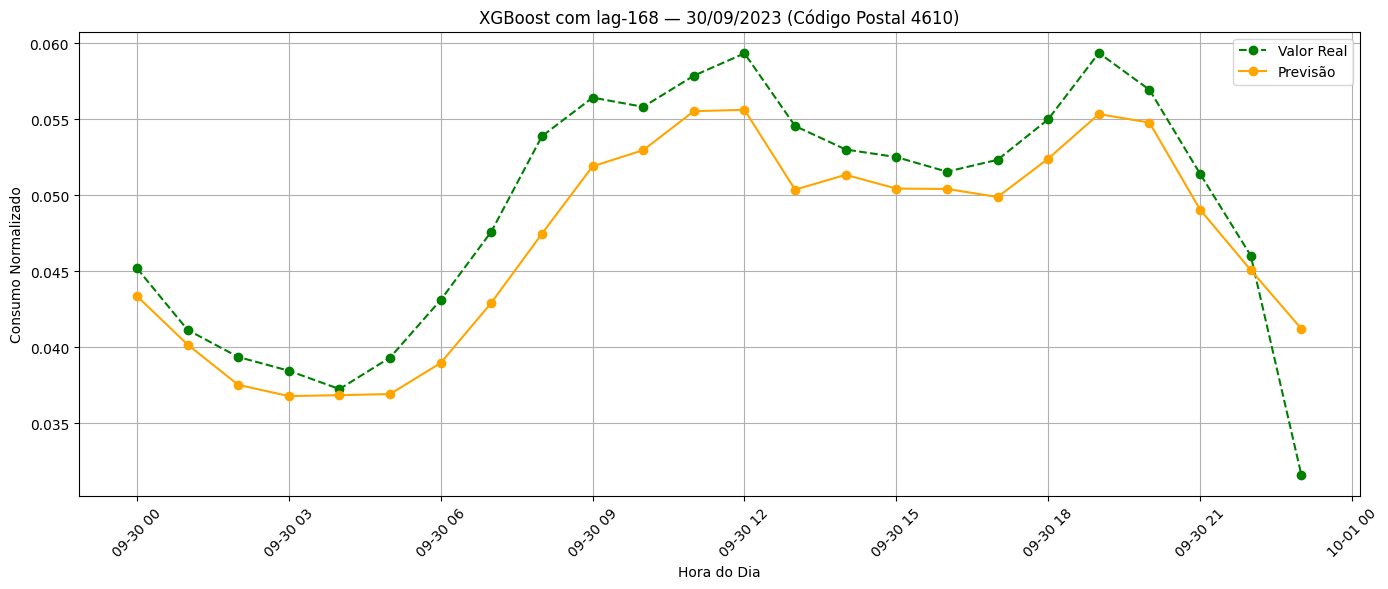

In [25]:
# Extrair os timestamps do índice
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("XGBoost com lag-168 — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/XGBoost_lag/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
O **XGBoost com lag-168**, utilizado para prever o consumo energético **normalizado** no dia **30/09/2023** para o código postal **4610**, apresentou um desempenho bastante sólido, com **MAE de 0.00295**, **RMSE de 0.00355**, **MAPE de 6.30%** e um **R² de 0.79258**. O gráfico evidencia uma boa capacidade do modelo em seguir a tendência geral dos valores reais, embora com alguma subestimação nos picos de consumo. Comparativamente, o **XGBoost superou o ARIMA com lag**, que teve desempenho muito fraco (MAPE de 47.82% e R² negativo), e ficou próximo do **Random Forest com lag** (MAPE de 6.95%, R² de 0.7368), apresentando previsões mais suaves. No entanto, os modelos **LSTM (MAPE de 3.94%, R² de 0.8541)** e **CNN (MAPE de 5.73%, R² de 0.7483)** tiveram um ajuste mais preciso, especialmente o LSTM, que continua a destacar-se como o modelo com melhor equilíbrio entre precisão e capacidade de generalização. Ainda assim, o XGBoost demonstrou ser uma solução eficiente e altamente competitiva para previsões horárias baseadas em variáveis temporais e lags sazonais.

# 📊Extra Trees

In [26]:
# Mantém só linhas completas
df_cp = df_cp.dropna(subset=["lag_168"]).copy()

# Static features
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
    .copy()
)

# Cria TimeSeriesDataFrame com target
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Variáveis exógenas conhecidas
known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_168"]

#### ✂️ Split treino/teste


In [27]:
# Divide os dados em treino e teste, reservando as últimas 24h como hold-out.
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo

In [ ]:
predictor_xt = TimeSeriesPredictor.load("./predicts/XT_lag/modelo/")

In [28]:
predictor_xt = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    known_covariates_names=known_covs,
    path="predicts/XT_lag/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
         "DirectTabular": {
            "models": ["XT"],      # só ExtraTrees
            "XT": {}               # parâmetros default
        }
    },
    presets="medium_quality",
    time_limit=600,
    skip_model_selection=True
)

predictor_xt.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\XT_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       2.40 GB / 15.93 GB (15.1%)
Disk Space Avail:   690.41 GB / 931.46 GB (74.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DirectTabular': {'XT': {}, 'models': ['XT']}},
 'known_covariates_names': ['Hour',
                            'TimeOfDay',
                            'Temperature',
                            'DayOfTheWeek',
                            'lag_168'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],

#### 🔮Preparação das covariáveis futuras para previsão

In [29]:
# 1.1) Pega último timestamp de train_data
last_time = train_data.index.get_level_values("timestamp").max()

# 1.2) Cria as 24 horas seguintes
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),
    periods=24,
    freq="h"
)

future_df = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 1.4) Converte para TimeSeriesDataFrame
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",
    timestamp_column="DateTime"
)[known_covs]

#### 📈 Previsão e avaliação

In [31]:
preds = predictor_xt.predict(
    data=train_data,
    known_covariates=future_known_covs
)

# Extrai a previsão pontual (mediana) e os valores reais correspondentes.
y_pred = preds["0.5"]
y_true = test_data["EnergyNormalized"].loc[preds.index]
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

Model not specified in predict, will default to the model with the best validation score: DirectTabular


#### 📊 Cálculo de métricas

In [32]:
MAE = np.abs(y_true - y_pred).mean()
MSE = ((y_true - y_pred) ** 2).mean()
RMSE = np.sqrt(MSE)
MAPE = (np.abs((y_true - y_pred) / y_true) * 100).mean()
R2 = r2_score(y_true, y_pred)

# Exportar métricas
metrics = {
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "MAPE": MAPE,
    "R²": R2
}

with open("predicts/XT_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {R2:.5f}")

MAE: 0.00295
MSE: 0.00001
RMSE: 0.00355
MAPE: 6.29957%
R²: 0.79258


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                      |
|----------------------------------------------|---------|-----------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00295 | Em média, a previsão difere dos valores reais em cerca de 0.00295 na escala normalizada.            |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado é baixo, o que indica boa consistência nas previsões.                      |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00355 | As previsões desviam-se em média 0.00355 dos valores reais, o que representa um erro reduzido.      |
| **MAPE** (Erro Percentual Absoluto Médio)    | 6.30%   | As previsões têm um erro percentual médio de 6.30%, considerado bom para séries horárias.           |
| **R²** (Coeficiente de Determinação)         | 0.79258 | O modelo explica cerca de 79.26% da variabilidade do consumo energético normalizado horário.        |

#### 🖼️ Visualização gráfica

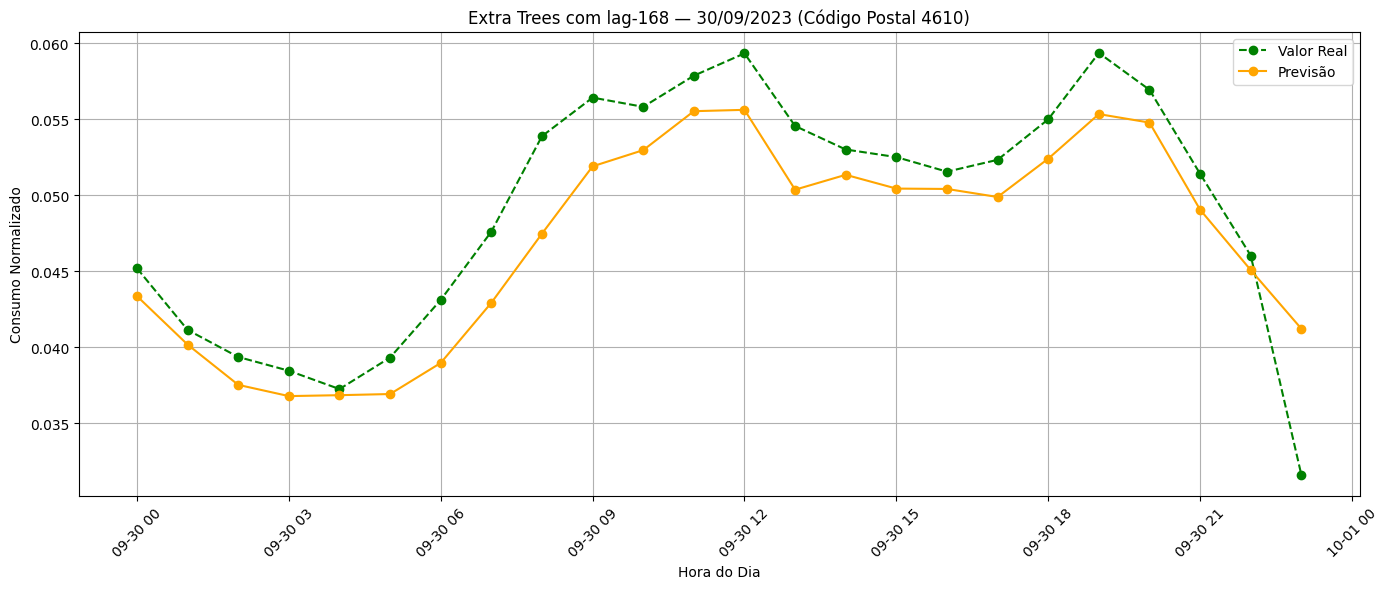

In [33]:
timestamps = preds.index.get_level_values("timestamp")
plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Extra Trees com lag-168 — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/XT_lag/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
O **Extra Trees com lag-168**, utilizado para prever o consumo energético **normalizado** no dia **30/09/2023** para o código postal **4610**, obteve um desempenho estável e competitivo, com **MAE de 0.00295**, **RMSE de 0.00355**, **MAPE de 6.30%** e um **R² de 0.79258**. Através do gráfico, observa-se que o modelo consegue acompanhar a tendência geral do consumo, embora apresente alguma subestimação nos períodos de pico. Em comparação, o Extra Trees supera amplamente o **ARIMA com lag-168**, que falhou na previsão horária (R² negativo e MAPE superior a 47%), e fica bastante próximo do **Random Forest com lag** (R² de 0.7368, MAPE de 6.95%). O desempenho do Extra Trees é semelhante ao do **XGBoost com lag** (R² de 0.7926, MAPE de 6.30%), confirmando que ambos os modelos de árvores são consistentes e eficazes para este tipo de tarefa. No entanto, tanto o **LSTM com lag-168** (R² de 0.8541, MAPE de 3.94%) quanto o **CNN com lag-168** (R² de 0.7483, MAPE de 5.73%) demonstraram uma capacidade superior de capturar padrões intradiários com maior precisão, especialmente nos extremos. Ainda assim, o Extra Trees revela-se uma excelente alternativa, sobretudo pelo seu equilíbrio entre desempenho e simplicidade de implementação.

# 📊NARX

In [34]:
# Mantém só linhas completas
df_cp = df_cp.dropna(subset=["lag_168"]).copy()

# Static features
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
    .copy()
)

# Cria TimeSeriesDataFrame com target
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Variáveis exógenas conhecidas
known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_168"]

#### ✂️ Split treino/teste

In [35]:
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo

In [ ]:
predictor_narx = TimeSeriesPredictor.load("./predicts/NARX_lag/modelo/")

In [36]:
predictor_narx = TimeSeriesPredictor(
    target="EnergyNormalized",
    freq="h",
    prediction_length=24,
    known_covariates_names=known_covs,
    path="predicts/NARX_lag/modelo"
).fit(
    train_data=train_data,
    tuning_data=test_data,
    hyperparameters={"DirectTabular": {}},
    time_limit=300,
    presets="medium_quality",
    skip_model_selection=True,  # pula ensembles avançados
)

predictor_narx.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\NARX_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       2.86 GB / 15.93 GB (17.9%)
Disk Space Avail:   690.34 GB / 931.46 GB (74.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DirectTabular': {}},
 'known_covariates_names': ['Hour',
                            'TimeOfDay',
                            'Temperature',
                            'DayOfTheWeek',
                            'lag_168'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 '

#### 📈 Previsão e avaliação

In [37]:
#    Use train_data para previsão à frente de 24h
preds = predictor_narx.predict(
    train_data,
    known_covariates=test_data
)

y_pred = preds["0.5"].droplevel(0)
y_true = (
    test_data["EnergyNormalized"]
    .droplevel(0)              # do TSDF para Series
    .loc[y_pred.index]         # só nas 24 horas previstas
)

Model not specified in predict, will default to the model with the best validation score: DirectTabular


#### 📊 Cálculo de métricas

In [38]:
MAE  = mean_absolute_error(y_true, y_pred)
MSE  = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)
MAPE = (np.abs((y_true - y_pred) / y_true) * 100).mean()
r2 = r2_score(y_true, y_pred)

# exportar metricas
metrics = {
    "MAE":   MAE,
    "MSE":   MSE,
    "RMSE":  RMSE,
    "MAPE":  MAPE,
    "R²": r2
}

with open("./predicts/NARX_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00296
MSE: 0.00001
RMSE: 0.00355
MAPE: 6.30599%
R²: 0.79221


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                       |
|----------------------------------------------|---------|------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00296 | Em média, a previsão difere dos valores reais em cerca de 0.00296 na escala normalizada.             |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado é baixo, indicando que os desvios entre previsões e valores reais são pequenos. |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00355 | As previsões apresentam um desvio típico de 0.00355 em relação aos valores reais.                    |
| **MAPE** (Erro Percentual Absoluto Médio)    | 6.31%   | As previsões têm um erro percentual médio de 6.31%, indicando boa precisão para uma série horária.   |
| **R²** (Coeficiente de Determinação)         | 0.79221 | O modelo explica cerca de 79.22% da variabilidade do consumo energético normalizado horário.         |

#### 🖼️ Visualização gráfica

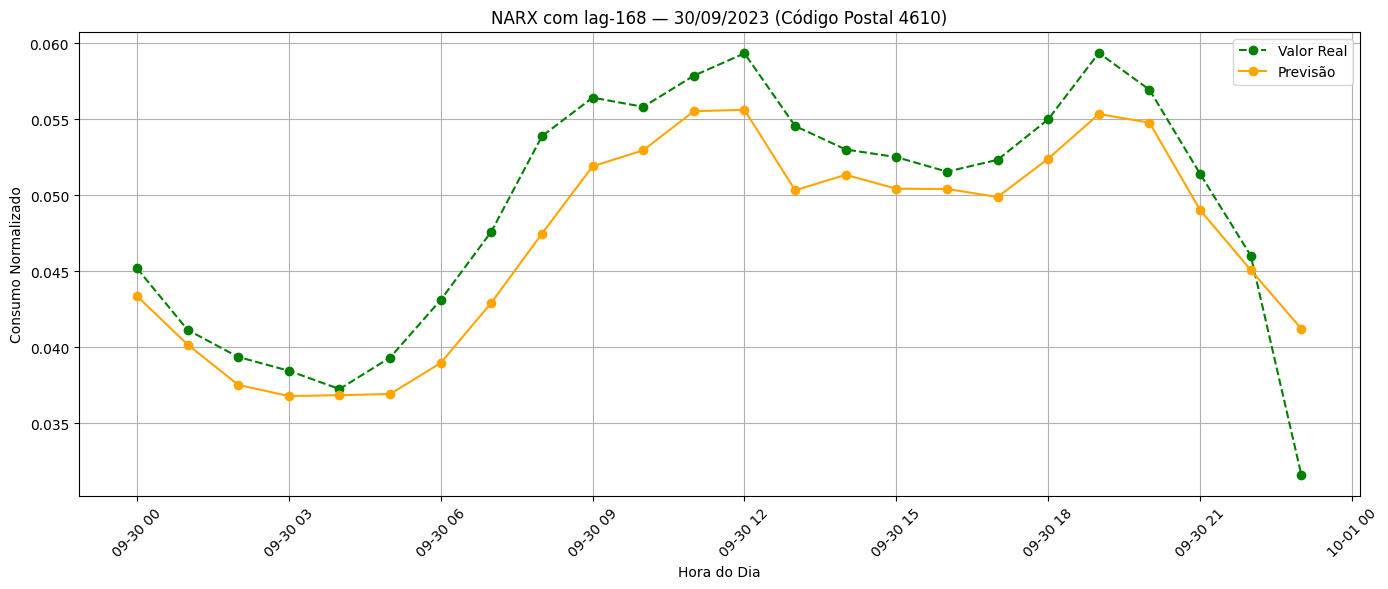

In [40]:
timestamps = preds.index.get_level_values("timestamp")
plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("NARX com lag-168 — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/NARX_lag/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
O **NARX com lag-168**, ao prever o consumo energético **normalizado** no dia **30/09/2023** para o código postal **4610**, demonstrou um desempenho consistente, com **MAE de 0.00296**, **RMSE de 0.00355**, **MAPE de 6.31%** e um **R² de 0.79221**. O gráfico revela que o modelo consegue seguir bem a tendência geral da série, embora com alguma subestimação nas horas de maior consumo. Comparando com os restantes modelos, o NARX supera com larga vantagem o **ARIMA com lag**, que falhou por completo (R² negativo, MAPE superior a 47%), e apresenta desempenho quase idêntico ao **Random Forest** (MAPE de 6.95%, R² de 0.7368), ao **XGBoost** (MAPE de 6.30%, R² de 0.7926) e ao **Extra Trees** (MAPE de 6.30%, R² de 0.7926). Ainda que fique ligeiramente atrás do **CNN** (MAPE de 5.73%, R² de 0.7483) e do **LSTM**, que continua a liderar com **MAPE de 3.94%** e **R² de 0.8541**, o modelo NARX confirma-se como uma alternativa robusta e eficaz para tarefas de previsão horária, especialmente quando se utilizam lags sazonais e variáveis temporais relevantes.

# 📊AutoML

In [11]:
# Mantém só linhas completas
df_cp = df_cp.dropna(subset=["lag_168"]).copy()

# Static features
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
    .copy()
)

# Cria TimeSeriesDataFrame com target
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Variáveis exógenas conhecidas
known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_168"]

#### ✂️ Split treino/teste

In [12]:
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo

In [13]:
predictor_AutoML = TimeSeriesPredictor.load("./predicts/AutoML_lag/modelo/")

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\AutoML_lag\modelo


In [7]:
# Treina o AutoML (vai testar vários modelos e eleger o melhor)
predictor_AutoML = TimeSeriesPredictor(
    target="EnergyNormalized",
    freq="h",
    prediction_length=24,
    known_covariates_names=known_covs,
    path="predicts/AutoML_lag/modelo"
).fit(
    train_data=train_data,
    tuning_data=test_data,
    presets="best",       # 'best' para máxima acurácia; 'medium_quality' para protótipo rápido
    time_limit=3200       # tempo limite em segundos
)

predictor_AutoML.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 3200s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\AutoML_lag\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       2.59 GB / 15.93 GB (16.3%)
Disk Space Avail:   690.20 GB / 931.46 GB (74.1%)
Setting presets to: best

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': ['Hour',
                            'TimeOfDay',
                            'Temperature',
                            'DayOfTheWeek',
                            'lag_168'],
 'num_val_windows': 2,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windo

#### 📈 Previsão e avaliação

In [14]:
#    Use train_data para previsão à frente de 24h
preds = predictor_AutoML.predict(
    train_data,
    known_covariates=test_data
)

y_pred = preds["0.5"].droplevel(0)
y_true = (
    test_data["EnergyNormalized"]
    .droplevel(0)              # do TSDF para Series
    .loc[y_pred.index]         # só nas 24 horas previstas
)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


#### 📊 Cálculo de métricas

In [15]:
MAE  = mean_absolute_error(y_true, y_pred)
MSE  = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)
MAPE = (np.abs((y_true - y_pred) / y_true) * 100).mean()
R2   = r2_score(y_true, y_pred)

# Exporta métricas para JSON
metrics = {
    "MAE":   MAE,
    "MSE":   MSE,
    "RMSE":  RMSE,
    "MAPE":  MAPE,
    "R²":    R2
}
with open("./predicts/AutoML_lag/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f"MAE:  {MAE:.5f}")
print(f"MSE:  {MSE:.5f}")
print(f"RMSE: {RMSE:.5f}")
print(f"MAPE: {MAPE:.2f}%")
print(f"R²:   {R2:.5f}")

MAE:  0.00135
MSE:  0.00001
RMSE: 0.00247
MAPE: 3.22%
R²:   0.89921


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                      |
|----------------------------------------------|---------|-----------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00135 | Em média, a previsão difere dos valores reais em apenas 0.00135 na escala normalizada.              |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado é muito baixo, indicando previsões bastante consistentes.                  |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00247 | O desvio típico das previsões em relação aos valores reais é de apenas 0.00247.                     |
| **MAPE** (Erro Percentual Absoluto Médio)    | 3.22%   | As previsões apresentam um erro percentual médio baixo, indicando elevada precisão.                 |
| **R²** (Coeficiente de Determinação)         | 0.89921 | O modelo explica cerca de 89.92% da variabilidade do consumo energético normalizado horário.        |

#### 🖼️ Visualização gráfica

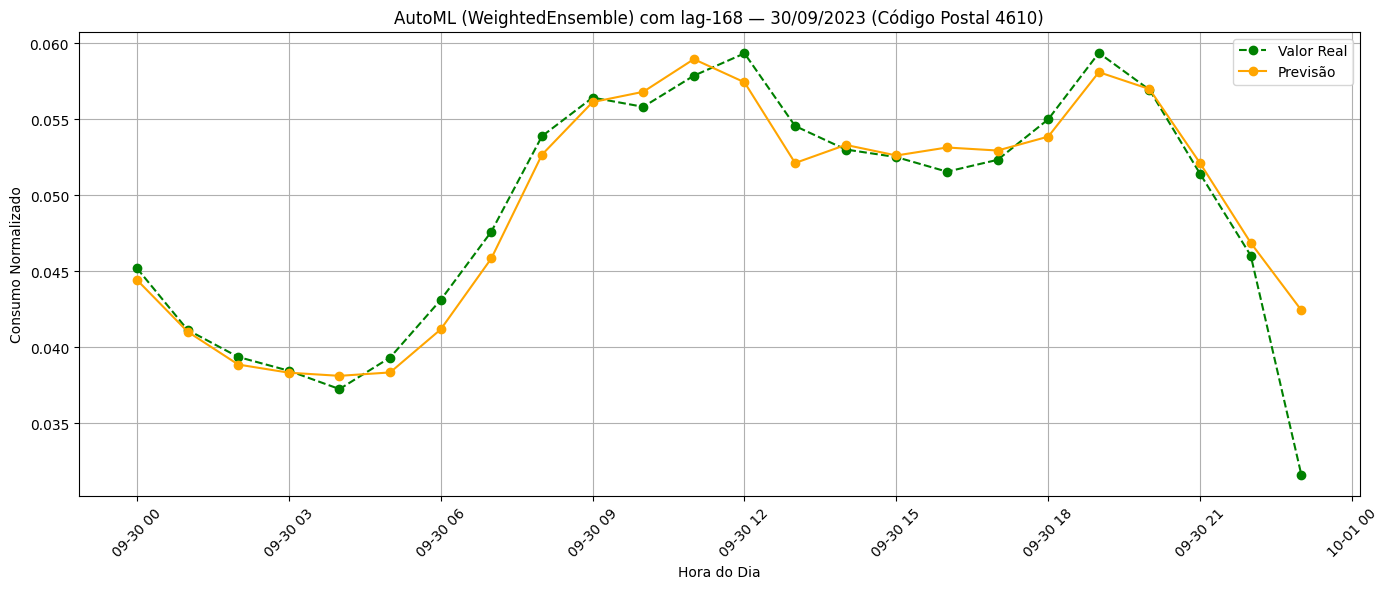

In [16]:
# Extrair os timestamps do índice
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("AutoML (WeightedEnsemble) com lag-168 — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/AutoML_lag/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📈Interpretação
O **AutoML (WeightedEnsemble) com lag-168**, utilizado para prever o consumo energético **normalizado** no dia **30/09/2023** para o código postal **4610**, destacou-se como um dos mais precisos entre todos os testados, com **MAE de 0.00135**, **RMSE de 0.00247**, **MAPE de 3.22%** e um excelente **R² de 0.89921**. Através do gráfico, é visível a elevada aderência das previsões aos valores reais ao longo das 24 horas, captando tanto os picos como os vales com grande fidelidade. Em comparação com o **ARIMA com lag**, que demonstrou desempenho muito fraco (R² negativo e MAPE acima de 47%), o AutoML apresenta melhorias drásticas. Supera também os modelos baseados em árvores como **Random Forest**, **Extra Trees** e **XGBoost**, que rondaram os 6.3% de MAPE e R² perto de 0.79, assim como o **CNN** (MAPE de 5.73%, R² de 0.7483). Apenas o **LSTM com lag** se aproxima do desempenho do AutoML, com MAPE de 3.94% e R² de 0.8541, embora ainda ligeiramente inferior. Estes resultados demonstram que o AutoML, ao combinar automaticamente os pontos fortes de múltiplos modelos através de ensemble, consegue atingir **uma precisão superior e robusta**, tornando-se a solução mais equilibrada e eficaz para esta tarefa de previsão horária.